# TASK


Get a spreadsheet with hypothetical transactional data. Imagine that you are
trying to understand if there is any kind of suspicious behavior.

1. Analyze the data provided and present your conclusions. What suspicious behaviors did
you find? What led you to this conclusion? What actions would you take?
2. In addition to the spreadsheet data, what other data would you consider to find patterns
of possible fraudulent behavior?
3. Considering your conclusions, what would you further suggest in order to prevent frauds
and/or chargebacks?

Some tips:
- User_id: id of the cardholders;
- Device_id: divice used by the cardholder;
- Has_cbk: transaction received a fraud chargeback or not;
- All the transactions occurred in a card not present environment;
- You can use any programming language that you want.

## Expected Deliveries

1. Analyse the data;
2. Create an anti-fraud solution;
3. Present the results and conclusions.

## Environment Setup

### Importing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap
import xgboost as xgb

c:\Users\cassi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Getting the data

In [2]:
DATA = pd.read_csv('../data/transactional-sample.csv')

## Data Overview

### Data Understanding

Goal: Gain a basic understanding of the dataset, including its structure, types of variables and initial patterns.

In [3]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


In [4]:
DATA.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


In [5]:
DATA.describe()

,transaction_id,merchant_id,user_id,transaction_amount,device_id
count,3.199000e+03,3199.000000,3199.000000,3199.000000,2369.000000
mean,2.132200e+07,48771.128790,50891.077212,767.812904,493924.859856
std,9.236161e+02,29100.360839,29515.282827,889.095904,283785.584545
min,2.132040e+07,16.000000,6.000000,1.220000,2.000000
25%,2.132120e+07,23426.000000,24267.500000,205.235000,259344.000000
50%,2.132200e+07,48752.000000,52307.000000,415.940000,495443.000000
75%,2.132280e+07,73915.000000,76837.000000,981.680000,733243.000000
max,2.132360e+07,99799.000000,99974.000000,4097.210000,999843.000000


In [6]:
print("\nNull values by each colunm:")
print(DATA.isnull().sum())

print("\nCategorical value counts:")
print(DATA['has_cbk'].value_counts())

print("\nUnique values by column:")
for col in DATA.columns:
    print(f"{col}: {DATA[col].nunique()}")


Null values by each colunm:
transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

Categorical value counts:
has_cbk
False    2808
True      391
Name: count, dtype: int64

Unique values by column:
transaction_id: 3199
merchant_id: 1756
user_id: 2704
card_number: 2925
transaction_date: 3199
transaction_amount: 3124
device_id: 1996
has_cbk: 2


In [7]:
print("Start date period:", pd.to_datetime(DATA['transaction_date']).min())
print("End date period:", pd.to_datetime(DATA['transaction_date']).max())

Start date period: 2019-11-01 01:27:15.811098
End date period: 2019-12-01 23:16:32.812632


### Summary

. The dataset contains 3,199 card-not-present transactions across 8 columns.

. Only `device_id` has missing values (830 nulls ≈ 26%).

. The target variable `has_cbk` (chargeback due to fraud) is highly imbalanced: 12.2% fraudulent (True), 87.8% legitimate (False).

. High cardinality in `user_id`, `card_number`, `transaction_id` and `transaction_date`.

. `transaction_amount` ranges from 1.22 to 4,097.21, with a mean of 767.81 – some high-value outliers may indicate risk.

. The dataset shows a diverse set of users, merchants and devices.

## Data Preparation

In [8]:
# convert to datetime
DATA['transaction_date'] = pd.to_datetime(DATA['transaction_date'])

# aux columns to help analysis
DATA['hour'] = DATA['transaction_date'].dt.hour
DATA['weekday'] = DATA['transaction_date'].dt.day_name()

## Data Analysis

**Comparing transaction amounts (with vs without chargeback)**


We can see that the most fraudulent transactions fall between the second and third quartiles (Q2 and Q3) of the transaction amount distribution. This suggests that fraudsters may be targeting moderately high amounts to avoid detection.

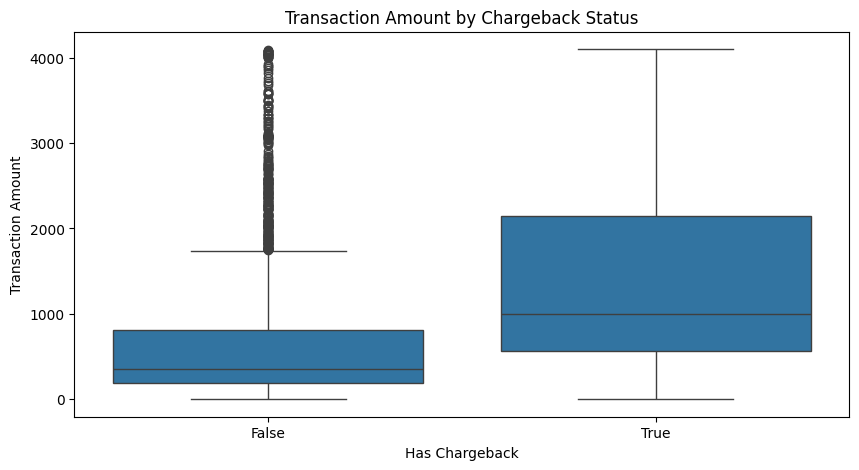

             25%      50%        75%
has_cbk                             
False    191.285  360.315   812.5775
True     565.580  999.470  2140.6800


In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=DATA, x='has_cbk', y='transaction_amount')
plt.title('Transaction Amount by Chargeback Status')
plt.xlabel('Has Chargeback')
plt.ylabel('Transaction Amount')

plt.show()

summary = DATA.groupby('has_cbk')['transaction_amount'].describe()

print(summary[['25%', '50%', '75%']])

**Comparing transactions in a short time by the same `user_id` and `merchant_id`**

The more transactions made within a short period of time, the higher the likelihood of fraud.

In [10]:
# Sort by user_id and date
df_user = DATA.sort_values(by=['user_id', 'transaction_date'])

# Calculate time between transactions
df_user['prev_date'] = df_user.groupby('user_id')['transaction_date'].shift(1)
df_user['time_diff_min'] = (df_user['transaction_date'] - df_user['prev_date']).dt.total_seconds() / 60

# Mark if the transaction occurred within 5 minutes of the previous one
df_user['fast_repeat'] = df_user['time_diff_min'] <= 60

# Count how many users have at least one fast repeat
users_fast = df_user.groupby('user_id')['fast_repeat'].sum().reset_index()
users_fast = users_fast[users_fast['fast_repeat'] >= 2]

print(f"Number of users with repeated transactions in <5 min: {users_fast.shape[0]}")

# Filter transactions with chargeback
frauds = DATA[DATA['has_cbk'] == True]

# Check how many of the users with fast transactions also have chargebacks
suspicious_users_with_cbk = users_fast[users_fast['user_id'].isin(frauds['user_id'])]

print(f"Number of users with fast transactions (<5min) and chargeback: {suspicious_users_with_cbk.shape[0]}")

Number of users with repeated transactions in <5 min: 39
Number of users with fast transactions (<5min) and chargeback: 31


In [11]:
# Sort transactions by card_number and transaction_date
df_card = DATA.sort_values(by=['card_number', 'transaction_date'])

# Calculate the time difference (in minutes) between consecutive transactions for each card
df_card['prev_date'] = df_card.groupby('card_number')['transaction_date'].shift(1)
df_card['time_diff_min'] = (df_card['transaction_date'] - df_card['prev_date']).dt.total_seconds() / 60

# Flag transactions that occurred within 60 minutes of the previous transaction for the same card
df_card['fast_repeat'] = df_card['time_diff_min'] <= 60

# Count cards with at least 2 fast repeated transactions (potential suspicious activity)
cards_fast = df_card.groupby('card_number')['fast_repeat'].sum().reset_index()
cards_fast = cards_fast[cards_fast['fast_repeat'] > 1]

print(f"Number of cards with repeated transactions in <60 min: {cards_fast.shape[0]}")

# Check how many of these suspicious cards also had chargebacks (fraud)
suspicious_cards_with_cbk = cards_fast[cards_fast['card_number'].isin(frauds['card_number'])]

print(f"Number of cards with fast repeated transactions (<60min) and chargeback: {suspicious_cards_with_cbk.shape[0]}")

Number of cards with repeated transactions in <60 min: 27
Number of cards with fast repeated transactions (<60min) and chargeback: 20


**Detect anomalous transactions based on user spending patterns using deviation**

The more a transaction amount deviates from a user’s usual transaction, the higher the likelihood of it being fraudulent.

In [12]:
def get_anomalous_transactions_by_user(data, z_thresh, min_tx_per_user=4):
    # Filter users with at least `min_tx_per_user` transactions
    user_counts = data['user_id'].value_counts()
    valid_users = user_counts[user_counts >= min_tx_per_user].index
    data_filtered = data[data['user_id'].isin(valid_users)].copy()

    # Calculate mean and standard deviation of transaction amounts per user
    stats = data_filtered.groupby('user_id')['transaction_amount'].agg(['mean', 'std']).reset_index()
    stats.columns = ['user_id', 'mean_amount', 'std_amount']

    # Merge the calculated stats back into the filtered dataset
    df = data_filtered.merge(stats, on='user_id', how='left')

    # Avoid division by zero by replacing szero standard deviations with a small value
    df['std_amount'] = df['std_amount'].replace(0, 1e-6)

    # Calculate the z-score for each transaction
    df['z_score'] = (df['transaction_amount'] - df['mean_amount']) / df['std_amount']

    # Filter transactions with a z-score above the specified threshold
    user_anomalies = df[df['z_score'] > z_thresh].copy()

    return user_anomalies

user_anomaly_df = get_anomalous_transactions_by_user(DATA, z_thresh=1, min_tx_per_user=6)

num_total = len(user_anomaly_df)
num_fraud = user_anomaly_df['has_cbk'].sum()

print(f"Total anomalous transactions based on user behavior: {num_total}")
print(f"Of these, fraudulent transactions (has_cbk=True): {num_fraud}")
print(f"Fraud proportion among anomalies: {num_fraud / num_total:.2%}")

Total anomalous transactions based on user behavior: 19
Of these, fraudulent transactions (has_cbk=True): 14
Fraud proportion among anomalies: 73.68%


In [13]:
def get_anomalous_transactions_by_merchant(data, z_thresh=1.5, min_tx_per_merchant=4):
    # Filter merchants with at least min_tx_per_merchant transactions
    merchant_counts = data['merchant_id'].value_counts()
    valid_merchants = merchant_counts[merchant_counts >= min_tx_per_merchant].index
    data_filtered = data[data['merchant_id'].isin(valid_merchants)].copy()

    # Calculate mean and standard deviation per merchant
    stats = data_filtered.groupby('merchant_id')['transaction_amount'].agg(['mean', 'std']).reset_index()
    stats.columns = ['merchant_id', 'mean_amount', 'std_amount']

    # Merge with the filtered data
    df = data_filtered.merge(stats, on='merchant_id', how='left')

    # Avoid division by zero
    df['std_amount'] = df['std_amount'].replace(0, 1e-6)

    # Calculate z-score
    df['z_score'] = (df['transaction_amount'] - df['mean_amount']) / df['std_amount']

    # Filter anomalous transactions
    merchant_anomalies = df[df['z_score'] > z_thresh].copy()

    return merchant_anomalies


merchant_anomaly_df = get_anomalous_transactions_by_merchant(DATA, z_thresh=1.2, min_tx_per_merchant=3)

num_total = len(merchant_anomaly_df)
num_fraud = merchant_anomaly_df['has_cbk'].sum()

print(f"Anomalous transactions by merchant (z > 1.5): {num_total}")
print(f"Of these, with has_cbk=True (fraud): {num_fraud}")
print(f"Fraud proportion among anomalies by merchant: {num_fraud / num_total:.2%}")

Anomalous transactions by merchant (z > 1.5): 134
Of these, with has_cbk=True (fraud): 30
Fraud proportion among anomalies by merchant: 22.39%


Distribution by time of day and day of week

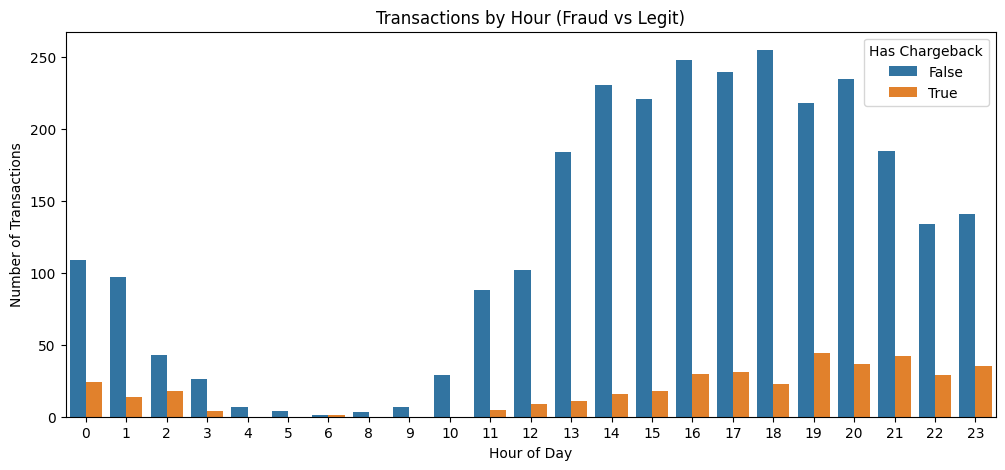

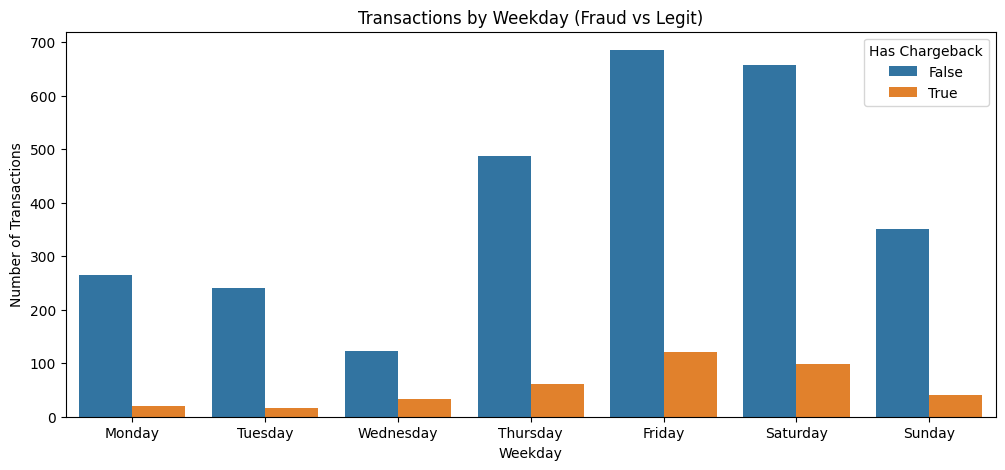

In [14]:
plt.figure(figsize=(12, 5))
sns.countplot(data=DATA, x='hour', hue='has_cbk')
plt.title('Transactions by Hour (Fraud vs Legit)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.legend(title='Has Chargeback')
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(data=DATA, x='weekday', hue='has_cbk', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Transactions by Weekday (Fraud vs Legit)')
plt.xlabel('Weekday')
plt.ylabel('Number of Transactions')
plt.legend(title='Has Chargeback')
plt.show()

Transactions without device_id and fraud risk


In [15]:
missing_device = DATA[DATA['device_id'].isna()]
fraud_rate_missing_device = missing_device['has_cbk'].mean()
fraud_rate_all = DATA['has_cbk'].mean()

print(f"Fraud rate without device_id: {fraud_rate_missing_device:.2%}")
print(f"Overall fraud rate: {fraud_rate_all:.2%}")

Fraud rate without device_id: 8.07%
Overall fraud rate: 12.22%


Devices used by many different users

In [16]:
device_user_count = DATA.groupby('device_id')['user_id'].nunique()
suspicious_devices = device_user_count[device_user_count > 1]

print(suspicious_devices.sort_values(ascending=False).head(10))

Series([], Name: user_id, dtype: int64)


Extra...

In [17]:
merchant_freq = DATA.groupby(['merchant_id', 'has_cbk']).size().unstack().fillna(0)
merchant_freq[True] = merchant_freq.get(True, 0)
merchant_freq[False] = merchant_freq.get(False, 0)

# Merchants with 1 transaction and no chargeback
merchants_1_tx_no_cbk = merchant_freq[(merchant_freq[False] == 1) & (merchant_freq[True] == 0)].index.tolist()

# Merchants with 1 transaction and with chargeback
merchants_1_tx_cbk = merchant_freq[(merchant_freq[True] == 1) & (merchant_freq[False] == 0)].index.tolist()

print(f"Merchants with exactly 1 transaction and NO chargeback: {len(merchants_1_tx_no_cbk)}")
print(f"Merchants with exactly 1 transaction and WITH chargeback: {len(merchants_1_tx_cbk)}")

Merchants with exactly 1 transaction and NO chargeback: 1206
Merchants with exactly 1 transaction and WITH chargeback: 36


In [18]:
# Filter fraudulent transactions
fraud_users = DATA[DATA['has_cbk'] == True]

# Check if they have a non-null device_id
fraud_users_with_device = fraud_users[fraud_users['device_id'].notna()]

# Count unique user_id with chargeback and a device_id
print("Unique user_id with has_cbk=True and device_id present:", fraud_users_with_device['user_id'].nunique())

# Optional: List of user_id
print(fraud_users_with_device['user_id'].unique())

Unique user_id with has_cbk=True and device_id present: 120
[ 2708 81152  5541  7725 10241 21768 11750 90182  7695  3157 90176 73867
 45420 31867 47604 50734 39443 17807 44494 66979 81164 50643 95694 59418
 99396 56877 97611 23429 90144 87048 12678 52129 73385 71424 21233 93679
  7281 55630 92034 69588  4651 96025  6761 68191 79054 91637 83258 92259
 66643 17929 67845 63582  9853 93767 89615 77999 19440  8743 10378 11065
  3584 27555 79237 86219 86411 76422 37113 53850 16862 89064 24644 12756
  4744 85612 83722 78262 57127 62888 96976 76768  9600 44531 99876 67519
 69466 41281 23916 35138 61047 31819 93156 70465   900 40493 27657 17507
 33805 92930 56139 45031 64057 43108 11452 58905 19199 38890 83826 28218
 65935 39334 61415 81642 96972 85897 38734 27987 57594  8761 43913 21702]


In [19]:
# Function to detect time pattern changes by user
def detect_time_pattern_change(df):
    # Convert hours to angles in radians (0 to 2pi)
    angles = (df['hour'] / 24) * 2 * np.pi
    
    # Circular mean using sine and cosine
    mean_sin = np.mean(np.sin(angles))
    mean_cos = np.mean(np.cos(angles))
    
    # Mean angle in radians
    mean_angle = np.arctan2(mean_sin, mean_cos)
    
    # Adjust to be between 0 and 2pi
    if mean_angle < 0:
        mean_angle += 2 * np.pi
    
    # Convert mean angle to hour (0 to 24)
    mean_hour = (mean_angle / (2 * np.pi)) * 24
    
    # Calculate circular difference between each hour and the average hour
    diff = np.abs(df['hour'] - mean_hour)
    diff = np.minimum(diff, 24 - diff)  # Minimum circular difference
    
    df['time_diff_from_avg'] = diff
    df['suspicious_time'] = df['time_diff_from_avg'] > 4  # > 6 hours outside the pattern
    
    return df


user_counts = DATA.groupby('user_id')['transaction_id'].count().reset_index(name='transaction_count')
eligible_users = user_counts[user_counts['transaction_count'] > 2]['user_id']

DATA_filtered = DATA[DATA['user_id'].isin(eligible_users)].copy()

# Apply by user (group_keys=False to avoid duplicate index)
fraud_extra = (
    DATA_filtered
    .set_index('user_id')
    .groupby('user_id', group_keys=False)
    .apply(detect_time_pattern_change)
    .reset_index()
)

# Count how many users have at least one transaction with suspicious timing
users_with_time_anomaly = fraud_extra.groupby('user_id')['suspicious_time'].any().reset_index()
users_with_time_anomaly_count = users_with_time_anomaly['suspicious_time'].sum()

print(f"\nNumber of users with abrupt changes in transaction time pattern: {users_with_time_anomaly_count}")

# Now, create a dataframe with anomaly and chargeback information per user
users_anomaly = fraud_extra.groupby('user_id').agg(
    has_time_anomaly=('suspicious_time', 'any'),
    has_chargeback=('has_cbk', 'any')  # user with at least 1 chargeback
).reset_index()

# Calculate chargeback rate for users with and without time anomalies
chargeback_rate = users_anomaly.groupby('has_time_anomaly')['has_chargeback'].mean().reset_index()

print("\nChargeback rate by time anomaly presence:")
print(chargeback_rate)



Number of users with abrupt changes in transaction time pattern: 26

Chargeback rate by time anomaly presence:
   has_time_anomaly  has_chargeback
0             False        0.722222
1              True        0.615385


In [20]:
def get_user_outliers(data):
    outliers_list = []

    for user_id, group in data.groupby('device_id'):
        
        q1 = group['transaction_amount'].quantile(0.25)
        q3 = group['transaction_amount'].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1 * iqr
        user_outliers = group[group['transaction_amount'] > upper_bound]
        outliers_list.append(user_outliers)

    # Concatenate all outliers into a single DataFrame
    return pd.concat(outliers_list, ignore_index=True)

# Execute and save in a new group
user_outlier_df = get_user_outliers(DATA)

# Count how many have has_cbk = True
num_total = len(user_outlier_df)
num_fraud = user_outlier_df['has_cbk'].sum()

print(f"Total outliers by user_id: {num_total}")
print(f"Outliers with fraud (has_cbk=True): {num_fraud}")
print(f"Proportion of frauds among outliers by user_id: {num_fraud / num_total:.2%}")

Total outliers by user_id: 12
Outliers with fraud (has_cbk=True): 8
Proportion of frauds among outliers by user_id: 66.67%


In [21]:
# --- Helper for user anomaly detection (z-score) ---
def get_user_stats(user_history, user_id):
    user_tx = user_history[user_history['user_id'] == user_id]
    if len(user_tx) < 6:
        return None, None
    mean = user_tx['transaction_amount'].mean()
    std = user_tx['transaction_amount'].std()
    if std == 0 or np.isnan(std):
        std = 1e-6
    return mean, std

# --- Enhanced fraud detection rules ---
def is_suspicious(transaction, user_history):
    reasons = []

    # Rule 1: very high value
    # if transaction['transaction_amount'] > 3000:
    #    reasons.append("High amount")

    # Rule 2: missing device_id
    # if pd.isna(transaction['device_id']):
    #    reasons.append("Missing device_id")

    # Rule 3: 3+ transactions in <1h with same card
    recent_card = user_history[
        (user_history['card_number'] == transaction['card_number']) &
        (user_history['transaction_date'] >= transaction['transaction_date'] - pd.Timedelta(hours=1))
    ]
    if len(recent_card) >= 3:
        reasons.append("Card repeated in <1h")

    # Rule 4: 2+ fast repeats (<60min) for this card_number (card-level pattern)
    card_history = user_history[user_history['card_number'] == transaction['card_number']]
    if len(card_history) >= 2:
        # Garante que transaction é DataFrame e datetime
        transaction_df = pd.DataFrame([transaction])
        transaction_df['transaction_date'] = pd.to_datetime(transaction_df['transaction_date'])
        card_history = pd.concat([card_history, transaction_df], ignore_index=True).sort_values('transaction_date')
        card_history['prev_date'] = card_history['transaction_date'].shift(1)
        card_history['time_diff_min'] = (card_history['transaction_date'] - card_history['prev_date']).dt.total_seconds() / 60
        fast_repeats = (card_history['time_diff_min'] <= 60).sum()
        if fast_repeats > 1:
            reasons.append("Card fast repeat pattern (<60min)")

    # Rule 5: 2+ fast repeats (<60min) for this user_id (user-level pattern)
    user_hist = user_history[user_history['user_id'] == transaction['user_id']]
    transaction_df = pd.DataFrame([transaction])
    transaction_df['transaction_date'] = pd.to_datetime(transaction_df['transaction_date'])
    user_history_sorted = pd.concat([user_hist, transaction_df], ignore_index=True).sort_values('transaction_date')
    user_history_sorted['prev_date'] = user_history_sorted['transaction_date'].shift(1)
    user_history_sorted['time_diff_min'] = (user_history_sorted['transaction_date'] - user_history_sorted['prev_date']).dt.total_seconds() / 60
    fast_repeats_user = (user_history_sorted['time_diff_min'] <= 60).sum()
    if fast_repeats_user >= 2:
        reasons.append("User fast repeat pattern (<60min)")

    # Rule 6: Anomalous transaction by user z-score
    mean, std = get_user_stats(user_history, transaction['user_id'])
    if mean is not None and std is not None:
        z_score = (transaction['transaction_amount'] - mean) / std
        if z_score > 1:
            reasons.append("User anomaly (z-score > 1)")

    suspicious = len(reasons) > 0
    return suspicious, "; ".join(reasons)

# --- Real-time processing, returns DataFrame with results ---
def process_stream(transactions):
    user_history = pd.DataFrame(columns=transactions.columns)
    results = []
    for idx, row in transactions.iterrows():
        suspicious, reason = is_suspicious(row, user_history)
        results.append({
            'transaction_id': row['transaction_id'],
            'has_cbk': row['has_cbk'],
            'detected_fraud': suspicious,
            'fraud_reason': reason if suspicious else ""
        })
        user_history = pd.concat([user_history, pd.DataFrame([row])], ignore_index=True)
    return pd.DataFrame(results)

# Example usage:
results_df = process_stream(DATA)


C:\Users\cassi\AppData\Local\Temp\ipykernel_42784\1464473327.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_history_sorted = pd.concat([user_hist, transaction_df], ignore_index=True).sort_values('transaction_date')
C:\Users\cassi\AppData\Local\Temp\ipykernel_42784\1464473327.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_history = pd.concat([user_history, pd.DataFrame([row])], ignore_index=True)


In [22]:
results_df[results_df['has_cbk'] == True][['detected_fraud', 'fraud_reason']].value_counts()

detected_fraud  fraud_reason                                                                              
False                                                                                                         278
True            User fast repeat pattern (<60min)                                                              74
                Card fast repeat pattern (<60min); User fast repeat pattern (<60min)                           15
                Card repeated in <1h; Card fast repeat pattern (<60min); User fast repeat pattern (<60min)     15
                User fast repeat pattern (<60min); User anomaly (z-score > 1)                                   6
                Card repeated in <1h                                                                            3
Name: count, dtype: int64

C:\Users\cassi\AppData\Local\Temp\ipykernel_42784\270864931.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
C:\Users\cassi\AppData\Local\Temp\ipykernel_42784\270864931.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
C:\Users\cassi\AppData\Local\Temp\ipykerne

transaction_amount        0
hour                      0
card_number               0
user_id                   0
merchant_id               0
device_id                 0
time_since_last_tx        0
tx_last_24h               0
mean_amount_last5         0
std_amount_last5          0
user_mean_amount          0
user_median_amount        0
user_std_amount           0
amount_vs_user_mean       0
amount_vs_user_median     0
amount_zscore_user        0
amount_deviation_user     0
amount_percentile_user    0
is_new_device             0
is_new_merchant           0
is_new_card               0
tx_last_1h                0
tx_last_6h                0
tx_last_7d                0
user_amount_trend         0
dtype: int64


c:\Users\cassi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[778  82]
 [ 21  79]]

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.90      0.94       860
        True       0.49      0.79      0.61       100

    accuracy                           0.89       960
   macro avg       0.73      0.85      0.77       960
weighted avg       0.92      0.89      0.90       960

ROC AUC Score: 0.9001
Precision-Recall AUC: 0.6197


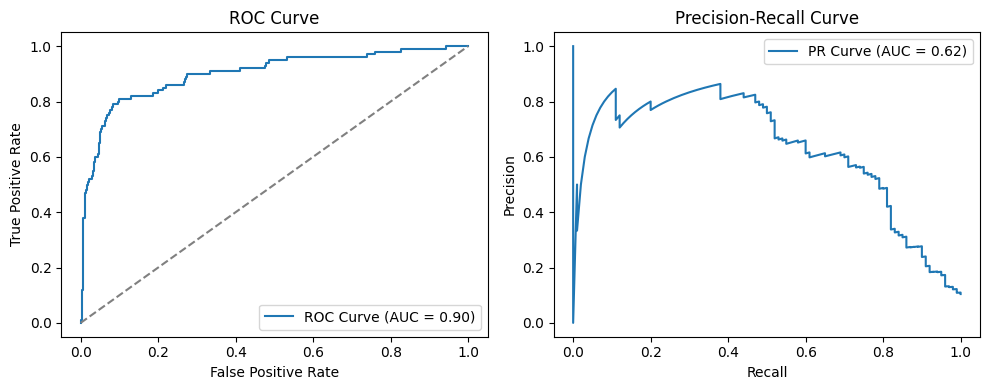

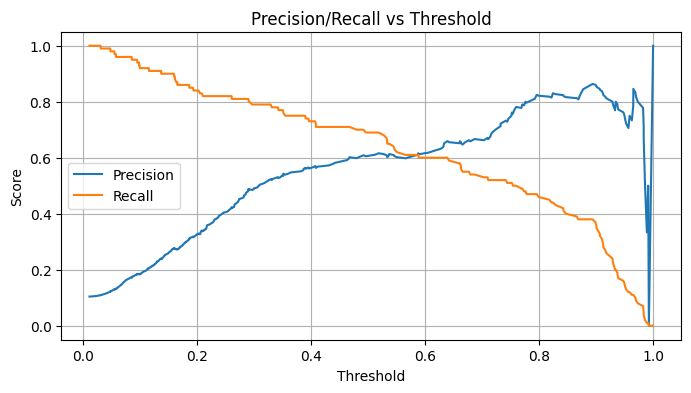

C:\Users\cassi\AppData\Local\Temp\ipykernel_42784\270864931.py:272: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')


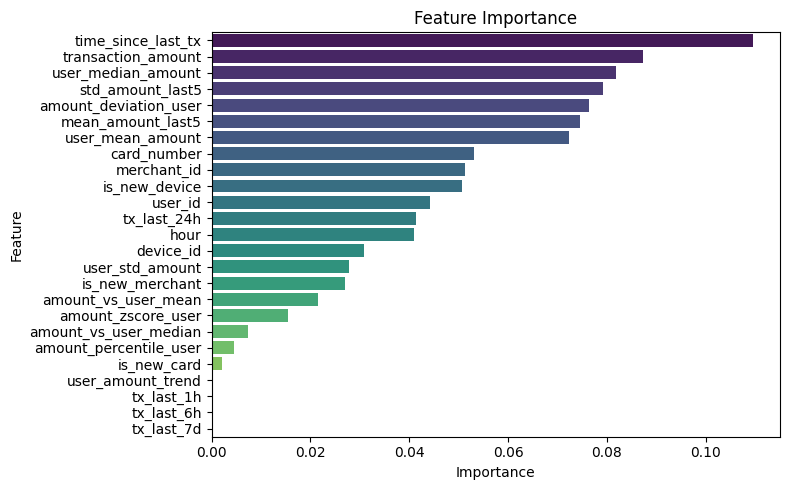


Feature Importances:
                    Feature  Importance
6       time_since_last_tx    0.109558
0       transaction_amount    0.087224
11      user_median_amount    0.081940
9         std_amount_last5    0.079162
16   amount_deviation_user    0.076367
8        mean_amount_last5    0.074509
10        user_mean_amount    0.072385
2              card_number    0.053200
4              merchant_id    0.051366
18           is_new_device    0.050621
3                  user_id    0.044276
7              tx_last_24h    0.041470
1                     hour    0.040913
5                device_id    0.030756
12         user_std_amount    0.027823
19         is_new_merchant    0.027020
13     amount_vs_user_mean    0.021590
15      amount_zscore_user    0.015476
14   amount_vs_user_median    0.007474
17  amount_percentile_user    0.004598
20             is_new_card    0.002031
24       user_amount_trend    0.000243
21              tx_last_1h    0.000000
22              tx_last_6h    0.000000
23

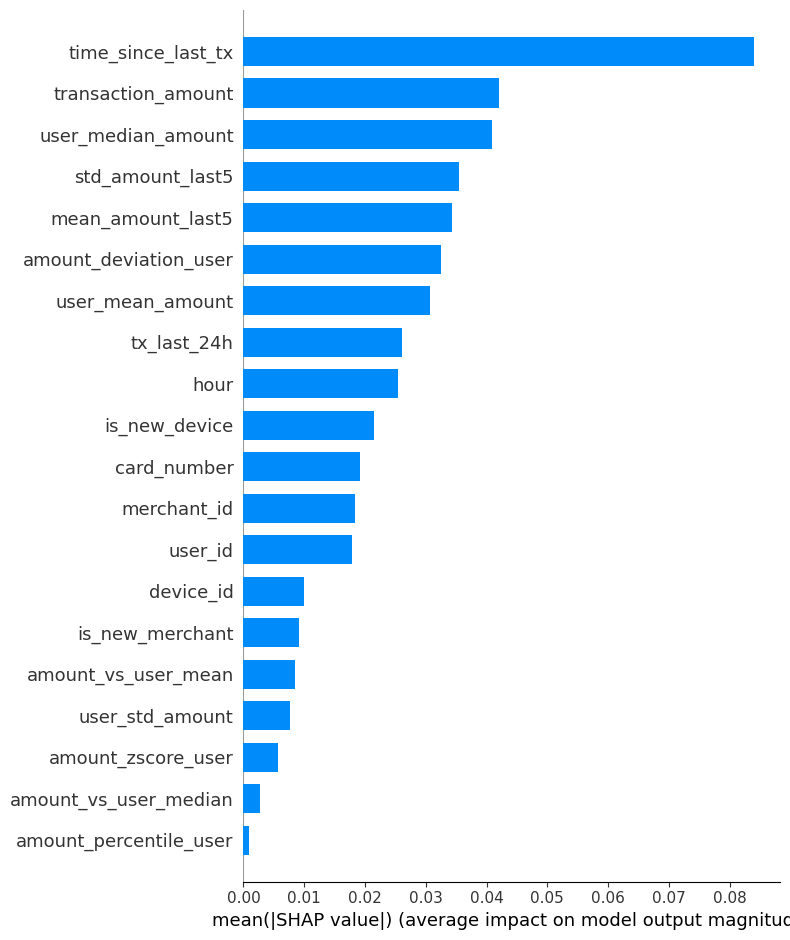

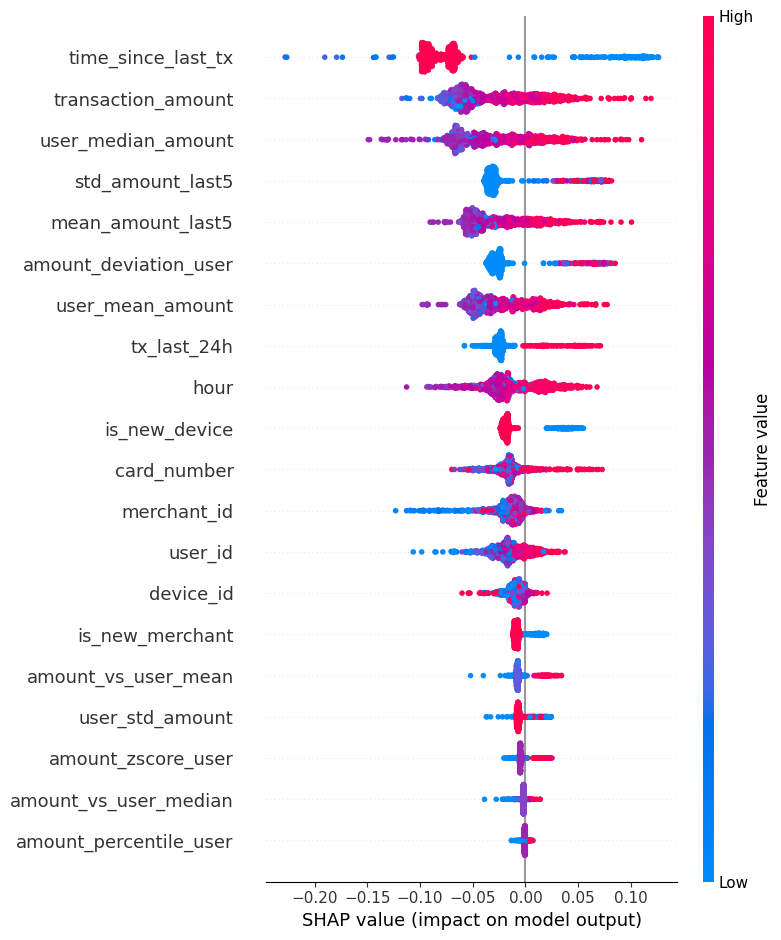

In [26]:
# =============================
# 1. ADVANCED FEATURE ENGINEERING PREPROCESSING
# =============================

def preprocess_data(data):
    data = data.copy()
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])
    data['hour'] = data['transaction_date'].dt.hour
    data['transaction_amount'] = np.log1p(data['transaction_amount'].fillna(0))
    
    data = data.sort_values(['user_id', 'transaction_date'])

    # Time since the user's last transaction (in minutes)
    data['prev_date'] = data.groupby('user_id')['transaction_date'].shift(1)
    data['time_since_last_tx'] = (data['transaction_date'] - data['prev_date']).dt.total_seconds() / 60
    data['time_since_last_tx'] = data['time_since_last_tx'].fillna(99999)

    # Number of user transactions in the last 24 hours (efficient)
    data['tx_last_24h'] = 0
    for user_id, user_df in data.groupby('user_id'):
        idx = user_df.index
        user_df = user_df.set_index('transaction_date')
        tx_last_24h = user_df['has_cbk'].rolling('24h', closed='left').count()
        tx_last_24h = tx_last_24h.fillna(0)
        data.loc[idx, 'tx_last_24h'] = tx_last_24h.values

    # Behavioral features: mean and std of the last 5 user transaction amounts
    data['mean_amount_last5'] = (
        data.groupby('user_id')['transaction_amount']
        .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    )
    data['std_amount_last5'] = (
        data.groupby('user_id')['transaction_amount']
        .transform(lambda x: x.rolling(window=5, min_periods=1).std().fillna(0))
    )

    # ======================
    # ADVANCED FEATURE ENGINEERING
    # ======================

    # Mean, median, std of transaction amounts per user (expanding: up to the moment)
    data['user_mean_amount'] = data.groupby('user_id')['transaction_amount'].transform(lambda x: x.expanding().mean())
    data['user_median_amount'] = data.groupby('user_id')['transaction_amount'].transform(lambda x: x.expanding().median())
    data['user_std_amount'] = data.groupby('user_id')['transaction_amount'].transform(lambda x: x.expanding().std().replace(0, 1).fillna(1))

    # Value relative to the user's mean/history
    data['amount_vs_user_mean'] = data['transaction_amount'] / data['user_mean_amount']
    data['amount_vs_user_median'] = data['transaction_amount'] / data['user_median_amount']
    data['amount_zscore_user'] = (data['transaction_amount'] - data['user_mean_amount']) / data['user_std_amount']

    # Absolute deviation of the transaction amount relative to the user's mean
    data['amount_deviation_user'] = np.abs(data['transaction_amount'] - data['user_mean_amount'])

    # Percentile of the transaction amount in the user's previous transactions
    def rolling_percentile(x):
        pctls = []
        for i in range(len(x)):
            if i == 0:
                pctls.append(0.5)
            else:
                pctls.append((x.iloc[:i] < x.iloc[i]).mean())
        return pd.Series(pctls, index=x.index)
    data['amount_percentile_user'] = data.groupby('user_id')['transaction_amount'].transform(rolling_percentile)

    # Novelty of device, merchant, and card for the user
    data['is_new_device'] = (data.groupby('user_id')['device_id']
                                .transform(lambda x: ~x.duplicated()).astype(int))
    data['is_new_merchant'] = (data.groupby('user_id')['merchant_id']
                                .transform(lambda x: ~x.duplicated()).astype(int))
    data['is_new_card'] = (data.groupby('user_id')['card_number']
                                .transform(lambda x: ~x.duplicated()).astype(int))

    # Transaction frequency in time windows
    data['tx_last_1h'] = (data.groupby('user_id')
        .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
            .rolling('1h', closed='left').count())
        .reset_index(level=0, drop=True))
    data['tx_last_6h'] = (data.groupby('user_id')
        .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
            .rolling('6h', closed='left').count())
        .reset_index(level=0, drop=True))
    data['tx_last_7d'] = (data.groupby('user_id')
        .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
            .rolling('7d', closed='left').count())
        .reset_index(level=0, drop=True))

    # User trend (linear regression of value over time, rolling window of 10 transactions)
    def rolling_trend(series):
        trends = []
        for i in range(len(series)):
            if i < 9:
                trends.append(np.nan)
            else:
                y = series.iloc[i-9:i+1].values
                x = np.arange(10)
                coef = np.polyfit(x, y, 1)[0]
                trends.append(coef)
        return pd.Series(trends, index=series.index)
    data['user_amount_trend'] = data.groupby('user_id')['transaction_amount'].transform(rolling_trend)

    # User chargeback proportion up to the moment
    if 'has_cbk' in data.columns:
        data['user_cbk_rate'] = data.groupby('user_id')['has_cbk'].transform(lambda x: x.expanding().mean().fillna(0))
    else:
        data['user_cbk_rate'] = 0

    # Replace possible infinities and NaNs resulting from divisions
    data = data.replace([np.inf, -np.inf], np.nan).fillna(0)

    # ======================
    # CATEGORICAL ENCODING
    # ======================
    label_encoders = {}
    for col in ['card_number', 'user_id', 'merchant_id', 'device_id']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

    # ======================
    # FEATURE SELECTION: include the new features!
    # ======================
    features = [
        'transaction_amount', 'hour', 'card_number', 'user_id', 'merchant_id', 'device_id',
        'time_since_last_tx', 'tx_last_24h', 'mean_amount_last5', 'std_amount_last5',
        'user_mean_amount', 'user_median_amount', 'user_std_amount',
        'amount_vs_user_mean', 'amount_vs_user_median', 'amount_zscore_user',
        'amount_deviation_user', 'amount_percentile_user',
        'is_new_device', 'is_new_merchant', 'is_new_card',
        'tx_last_1h', 'tx_last_6h', 'tx_last_7d',
        'user_amount_trend'
    ]
    X = data[features].copy()

    # Scaling numerical features
    scaler = StandardScaler()
    num_cols = [
        'transaction_amount', 'hour', 'time_since_last_tx', 'tx_last_24h', 'mean_amount_last5', 'std_amount_last5',
        'user_mean_amount', 'user_median_amount', 'user_std_amount',
        'amount_vs_user_mean', 'amount_vs_user_median', 'amount_zscore_user',
        'amount_deviation_user', 'amount_percentile_user',
        'tx_last_1h', 'tx_last_6h', 'tx_last_7d',
        'user_amount_trend'
    ]
    X[num_cols] = scaler.fit_transform(X[num_cols])

    y = data['has_cbk'].values

    return X, y, scaler, label_encoders, features, num_cols

# =============================
# 2. THRESHOLD ADJUSTMENT
# =============================

def plot_precision_threshold(y_test, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    thresholds = np.append(thresholds, 1.0)  # To align array sizes

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision/Recall vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()

# =============================
# 3. MODELING AND ENSEMBLE
# =============================

def train_and_evaluate_ensemble(X, y, scaler, label_encoders, features, num_cols, threshold=0.4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Ensemble: RandomForest + GradientBoosting + LogisticRegression
    ensemble_model = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(
                n_estimators=500, min_samples_split=10, min_samples_leaf=2,
                max_features='sqrt', max_depth=25, bootstrap=True,
                class_weight='balanced_subsample', random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=250, max_depth=5, random_state=42)),
            ('lr', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42))
        ],
        voting='soft'
    )

    ensemble_model.fit(X_train, y_train)

    y_proba = ensemble_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

    # Save models and encoders
    joblib.dump(ensemble_model, 'fraud_ensemble_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(label_encoders, 'label_encoders.pkl')

    return ensemble_model, y_test, y_pred, y_proba, X_test

# =============================
# 4. HYPERPARAMETER TUNING
# =============================

def hyperparameter_tuning(X_train, y_train):
    param_dist = {
        'n_estimators': [200, 300, 400, 500, 600],
        'max_depth': [10, 15, 20, 25, 30],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='precision', n_jobs=-1)
    search.fit(X_train, y_train)
    print("Best params:", search.best_params_)
    return search.best_estimator_

# =============================
# 5. VISUALIZATIONS
# =============================

def plot_curves(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %.2f)' % roc_auc_score(y_test, y_proba))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='PR Curve (AUC = %.2f)' % auc(recall, precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, X):
    # Only works for tree-based models
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "estimators_") and hasattr(model.estimators_[0], "feature_importances_"):
        # VotingClassifier: get importance from the first estimator
        importances = model.estimators_[0].feature_importances_
    else:
        print("Feature importance not available for this model.")
        return None

    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return feature_importances

# =============================
# 6. EXPLAINABILITY WITH SHAP
# =============================

def shap_explain(model, X_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    # For 3D arrays (n samples, n features, n classes)
    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_vals_positive = shap_values[:, :, 1]
        shap.summary_plot(shap_vals_positive, X_test, plot_type="bar")
        shap.summary_plot(shap_vals_positive, X_test)
        shap.initjs()
        shap.plots.force(explainer.expected_value[1], shap_vals_positive[0], X_test.iloc[0])
    # Other situations (default list)
    elif isinstance(shap_values, list) and len(shap_values) == 2:
        shap.summary_plot(shap_values[1], X_test, plot_type="bar")
        shap.summary_plot(shap_values[1], X_test)
        shap.initjs()
        shap.plots.force(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])
    else:
        shap.summary_plot(shap_values, X_test, plot_type="bar")
        shap.summary_plot(shap_values, X_test)
        shap.initjs()
        shap.plots.force(explainer.expected_value, shap_values[0], X_test.iloc[0])

# =============================
# 7. FINAL EXECUTION
# =============================

# Assuming you already have the DATA variable loaded
X, y, scaler, label_encoders, features, num_cols = preprocess_data(DATA)

print(X.isnull().sum())
ensemble_model, y_test, y_pred, y_proba, X_test = train_and_evaluate_ensemble(
    X, y, scaler, label_encoders, features, num_cols, threshold=0.3
)
plot_curves(y_test, y_proba)
plot_precision_threshold(y_test, y_proba)
feature_importances = plot_feature_importance(ensemble_model.estimators_[0], X) # RandomForest from the ensemble
print("\nFeature Importances:\n", feature_importances)

# SHAP explainability
shap_explain(ensemble_model.estimators_[0], X_test) # Explains RandomForest


C:\Users\cassi\AppData\Local\Temp\ipykernel_42784\267756428.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
C:\Users\cassi\AppData\Local\Temp\ipykernel_42784\267756428.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
C:\Users\cassi\AppData\Local\Temp\ipykerne

Confusion Matrix:
[[816  27]
 [ 33  84]]

Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.97      0.96       843
        True       0.76      0.72      0.74       117

    accuracy                           0.94       960
   macro avg       0.86      0.84      0.85       960
weighted avg       0.94      0.94      0.94       960

ROC AUC Score: 0.9329
Precision-Recall AUC: 0.8197


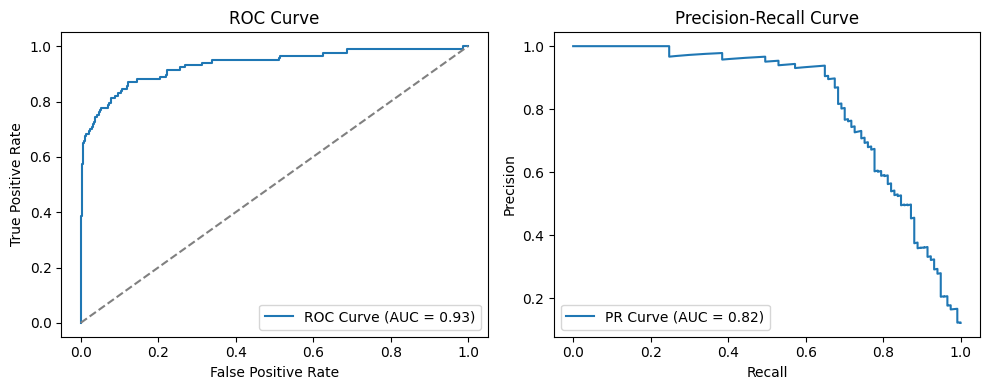

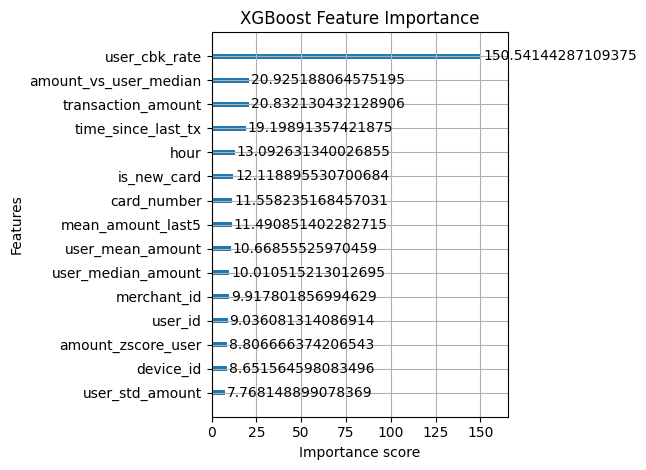

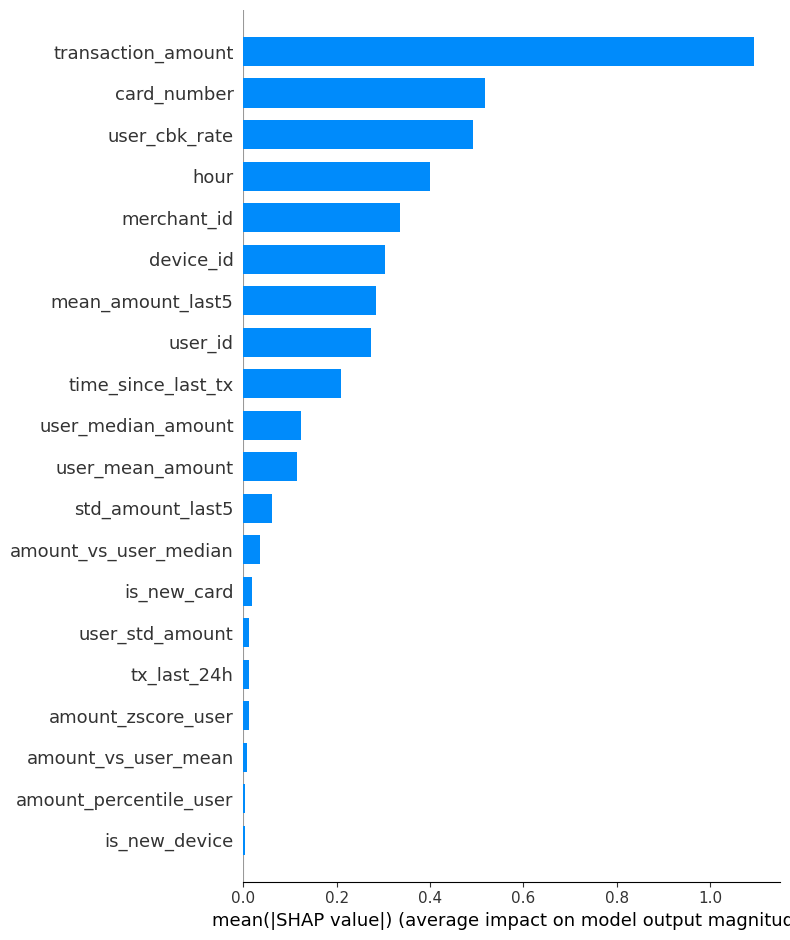

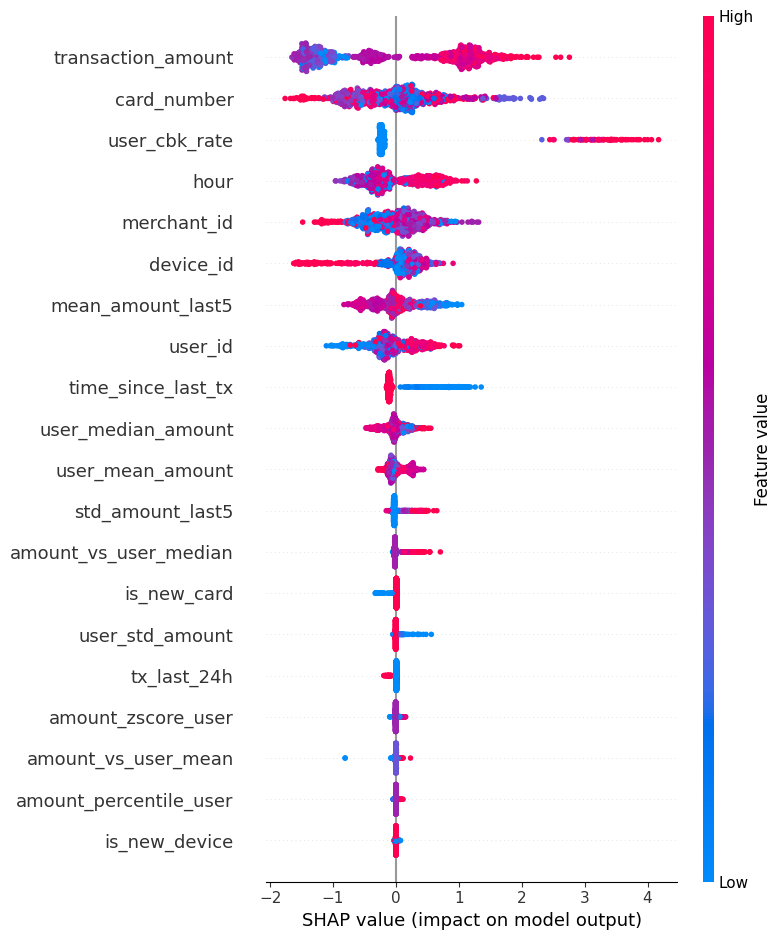

ROC AUC in each fold: [0.91094078 0.92186787 0.9415777  0.90924885 0.92136295]
Mean ROC AUC: 0.9209996309574192


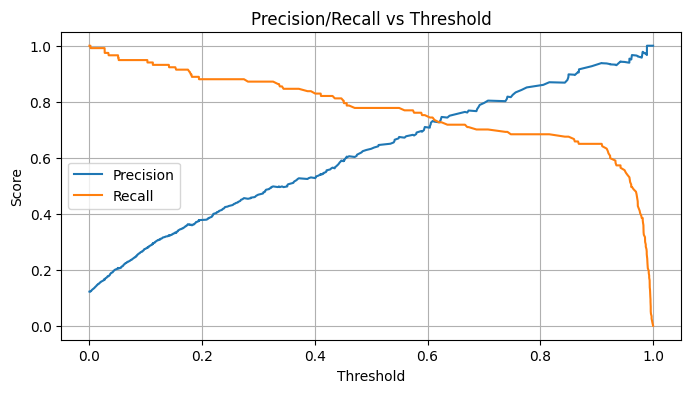

In [24]:
# =============================
# 1. DATA PREPROCESSING (reuse as in your pipeline)
# =============================

def preprocess_data(data):
    data = data.copy()
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])
    data['hour'] = data['transaction_date'].dt.hour
    data['transaction_amount'] = np.log1p(data['transaction_amount'].fillna(0))
    data = data.sort_values(['user_id', 'transaction_date'])

    data['user_cbk_rate'] = (
        data.groupby('user_id')['has_cbk']
        .transform(lambda x: x.shift().expanding().mean())
        .fillna(0)
    )

    data['prev_date'] = data.groupby('user_id')['transaction_date'].shift(1)
    data['time_since_last_tx'] = (data['transaction_date'] - data['prev_date']).dt.total_seconds() / 60
    data['time_since_last_tx'] = data['time_since_last_tx'].fillna(99999)

    data['tx_last_24h'] = 0
    for user_id, user_df in data.groupby('user_id'):
        idx = user_df.index
        user_df = user_df.set_index('transaction_date')
        tx_last_24h = user_df['has_cbk'].rolling('24h', closed='left').count()
        data.loc[idx, 'tx_last_24h'] = tx_last_24h.values

    data['mean_amount_last5'] = (
        data.groupby('user_id')['transaction_amount']
        .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    )
    data['std_amount_last5'] = (
        data.groupby('user_id')['transaction_amount']
        .transform(lambda x: x.rolling(window=5, min_periods=1).std().fillna(0))
    )

    # Advanced feature engineering (same as previous pipeline)
    data['user_mean_amount'] = data.groupby('user_id')['transaction_amount'].transform(lambda x: x.expanding().mean())
    data['user_median_amount'] = data.groupby('user_id')['transaction_amount'].transform(lambda x: x.expanding().median())
    data['user_std_amount'] = data.groupby('user_id')['transaction_amount'].transform(lambda x: x.expanding().std().replace(0, 1).fillna(1))
    data['amount_vs_user_mean'] = data['transaction_amount'] / data['user_mean_amount']
    data['amount_vs_user_median'] = data['transaction_amount'] / data['user_median_amount']
    data['amount_zscore_user'] = (data['transaction_amount'] - data['user_mean_amount']) / data['user_std_amount']

    def rolling_percentile(x):
        pctls = []
        for i in range(len(x)):
            if i == 0:
                pctls.append(0.5)
            else:
                pctls.append((x.iloc[:i] < x.iloc[i]).mean())
        return pd.Series(pctls, index=x.index)
    data['amount_percentile_user'] = data.groupby('user_id')['transaction_amount'].transform(rolling_percentile)

    data['is_new_device'] = (data.groupby('user_id')['device_id']
                                .transform(lambda x: ~x.duplicated()).astype(int))
    data['is_new_merchant'] = (data.groupby('user_id')['merchant_id']
                                .transform(lambda x: ~x.duplicated()).astype(int))
    data['is_new_card'] = (data.groupby('user_id')['card_number']
                                .transform(lambda x: ~x.duplicated()).astype(int))

    data['tx_last_1h'] = (data.groupby('user_id')
        .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
            .rolling('1h', closed='left').count())
        .reset_index(level=0, drop=True))
    data['tx_last_6h'] = (data.groupby('user_id')
        .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
            .rolling('6h', closed='left').count())
        .reset_index(level=0, drop=True))
    data['tx_last_7d'] = (data.groupby('user_id')
        .apply(lambda x: x.set_index('transaction_date')['transaction_amount']
            .rolling('7d', closed='left').count())
        .reset_index(level=0, drop=True))

    data = data.replace([np.inf, -np.inf], np.nan).fillna(0)

    label_encoders = {}
    for col in ['card_number', 'user_id', 'merchant_id', 'device_id']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

    features = [
        'transaction_amount', 'hour', 'card_number', 'user_id', 'merchant_id', 'device_id',
        'time_since_last_tx', 'tx_last_24h', 'mean_amount_last5', 'std_amount_last5',
        'user_mean_amount', 'user_median_amount', 'user_std_amount',
        'amount_vs_user_mean', 'amount_vs_user_median', 'amount_zscore_user',
        'amount_percentile_user',
        'is_new_device', 'is_new_merchant', 'is_new_card',
        'tx_last_1h', 'tx_last_6h', 'tx_last_7d',
        'user_cbk_rate'
    ]
    X = data[features].copy()

    scaler = StandardScaler()
    num_cols = [
        'transaction_amount', 'hour', 'time_since_last_tx', 'tx_last_24h', 'mean_amount_last5', 'std_amount_last5',
        'user_mean_amount', 'user_median_amount', 'user_std_amount',
        'amount_vs_user_mean', 'amount_vs_user_median', 'amount_zscore_user',
        'amount_percentile_user',
        'tx_last_1h', 'tx_last_6h', 'tx_last_7d',
        'user_cbk_rate'
    ]
    X[num_cols] = scaler.fit_transform(X[num_cols])

    y = data['has_cbk'].values

    return X, y, scaler, label_encoders, features, num_cols

# =============================
# 2. TRAINING AND EVALUATION XGBOOST
# =============================

def train_and_evaluate_xgb(X, y, scaler, label_encoders, threshold=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    xgb_model = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=3,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=1.0,
        scale_pos_weight=7.17, # or float from tuning
        gamma=1,
        min_child_weight=1,
        eval_metric='logloss',
        random_state=42,
        tree_method="hist"
    )

    xgb_model.fit(X_train, y_train)

    y_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

    joblib.dump(xgb_model, '../models/fraud_xgb_model.pkl')
    joblib.dump(scaler, '../models/scaler.pkl')
    joblib.dump(label_encoders, '../models/label_encoders.pkl')

    return xgb_model, y_test, y_pred, y_proba, X_test

# =============================
# 3. VISUALIZATIONSSS
# =============================

def plot_curves(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %.2f)' % roc_auc_score(y_test, y_proba))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='PR Curve (AUC = %.2f)' % auc(recall, precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_xgb_importance(model, X):
    xgb.plot_importance(model, importance_type='gain', max_num_features=15)
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

def plot_precision_threshold(y_test, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    thresholds = np.append(thresholds, 1.0)  # To align array sizes

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision/Recall vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()

# =============================
# 4. SHAP EXPLAINABILITY
# =============================

def shap_explain_xgb(model, X_test):
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    shap.summary_plot(shap_values, X_test)
    shap.initjs()
    shap.plots.force(shap_values[0])

# =============================
# 5. CROSS-VALIDATION
# =============================

def cross_validate_xgb(X, y):
    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(sum(y == 0) / sum(y == 1)),
        eval_metric='logloss',
        random_state=42,
        tree_method="hist"
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print("ROC AUC in each fold:", scores)
    print("Mean ROC AUC:", np.mean(scores))
    return scores

def xgb_hyperparameter_search(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 250, 500, 700],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5],
        'min_child_weight': [1, 3, 5, 7],
        'scale_pos_weight': [sum(y_train == 0) / sum(y_train == 1)]
    }

    xgb_model = xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        tree_method="hist"
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_dist,
        n_iter=30,                 # Increase for more search, decrease for faster results
        scoring='roc_auc',
        n_jobs=-1,
        cv=skf,
        verbose=2,
        random_state=42
    )

    search.fit(X_train, y_train)

    print("Best hyperparameters found:")
    print(search.best_params_)
    print(f"Best ROC AUC: {search.best_score_:.4f}")

    return search.best_estimator_


# =============================
# 6. FINAL EXECUTIONN FINAL EXECUTION
# =============================

X, y, scaler, label_encoders, features, num_cols = preprocess_data(DATA)
xgb_model, y_test, y_pred, y_proba, X_test = train_and_evaluate_xgb(X, y, scaler, label_encoders, threshold=0.65)

plot_curves(y_test, y_proba)
plot_xgb_importance(xgb_model, X)
shap_explain_xgb(xgb_model, X_test)
cross_validate_xgb(X, y)
plot_precision_threshold(y_test, y_proba)

In [25]:
DATA['date'] = DATA['transaction_date'].dt.date

# Group by day and hour, summing the transaction_amount and chargebacks
tx_by_day_hour = DATA.groupby(['date', 'hour']).agg(
    transaction_count=('transaction_id', 'count'),
    total_amount=('transaction_amount', 'sum'),
    chargeback_amount=('has_cbk', 'sum')
).reset_index().sort_values(by=['total_amount'], ascending=False)

# Descriptive statistics of the total values per group (day/hour)
print(tx_by_day_hour.describe())

# Display all rows of the grouped table
pd.set_option('display.max_rows', None)  # Show all rows
print(tx_by_day_hour)

             hour  transaction_count  total_amount  chargeback_amount
count  478.000000         478.000000    478.000000         478.000000
mean    13.786611           6.692469   5138.563766           0.817992
std      6.941842           7.507061   6161.212658           1.565593
min      0.000000           1.000000      1.220000           0.000000
25%     11.000000           2.000000    841.232500           0.000000
50%     15.000000           4.000000   2763.140000           0.000000
75%     19.000000           8.000000   7006.302500           1.000000
max     23.000000          34.000000  35125.020000           9.000000
           date  hour  transaction_count  total_amount  chargeback_amount
319  2019-11-22    22                 28      35125.02                  7
334  2019-11-23    17                 29      30088.87                  2
412  2019-11-28    17                 29      29247.16                  4
336  2019-11-23    19                 34      28994.78                  5
